# PROJECT : Fake Tweets with TFIDF

In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
downloaded = drive.CreateFile({'id':'18OnKZzKOkb3rZv_mgsvy6DP_z0bRVWHU'}) 
downloaded.GetContentFile('train.csv')

In [0]:
# For test file
download1 = drive.CreateFile({'id':'1rCir71bmCEDoEB9-4gXA8ZJxGjvx0DSk'})
downloaded.GetContentFile('test.csv')

In [0]:
# For Submission file
download2 = drive.CreateFile({'id':'1Mmx9ADQGtCzG93YwCil9idp0lPofDXdC'})
downloaded.GetContentFile('submission.csv')

In [65]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [66]:
!pip install scikit-plot

In [1]:
# importing the libaries

import pandas as pd
import numpy as np
import os

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

from plotly import tools
import plotly.offline as py
import plotly.figure_factory as ff
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

from nltk.corpus import stopwords
from nltk.util import ngrams

from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split , GridSearchCV , cross_val_score , KFold
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import classification_report , confusion_matrix , f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix , roc_curve , accuracy_score , precision_score , recall_score

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB , GaussianNB
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier

from collections import defaultdict
from collections import Counter
plt.style.use('ggplot')
stop=set(stopwords.words('english'))

import re
from nltk.tokenize import word_tokenize
import gensim
import string

from tqdm import tqdm
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D
from keras.initializers import Constant
from keras.optimizers import Adam

import folium 
from folium import plugins

#from spellchecker import SpellChecker

Using TensorFlow backend.


In [2]:
# Load the train and test dataset

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('submission.csv')

In [3]:
train.shape

(7613, 5)

In [4]:
train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [5]:
train.head(10)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


In [6]:
new_train = train
new_train['keyword'].fillna("No keyword",inplace=True)
new_train.isnull().sum()

id             0
keyword        0
location    2533
text           0
target         0
dtype: int64

In [7]:
# drop the location column both from train and test part

# train.drop(['location'] , axis = 1 , inplace = True)
# test.drop(['location'] , axis = 1 , inplace = True)

In [8]:
train.shape

(7613, 5)

## EDA

Text(0, 0.5, 'Number of samples')

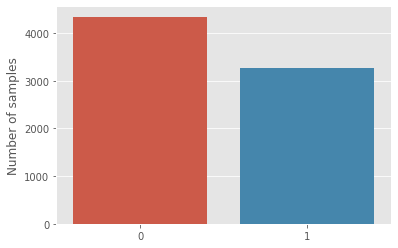

In [9]:
x=train.target.value_counts()
sns.barplot(x.index,x)
plt.gca().set_ylabel('Number of samples')

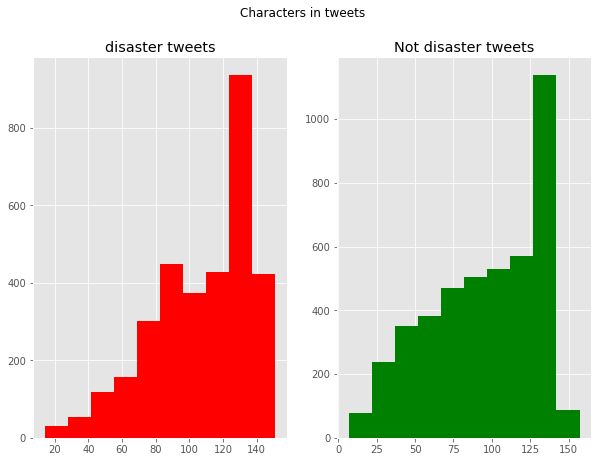

In [10]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,7))
tweet_len=train[train['target']==1]['text'].str.len()
ax1.hist(tweet_len,color='red')
ax1.set_title('disaster tweets')
tweet_len=train[train['target']==0]['text'].str.len()
ax2.hist(tweet_len,color='green')
ax2.set_title('Not disaster tweets')
fig.suptitle('Characters in tweets')
plt.show()

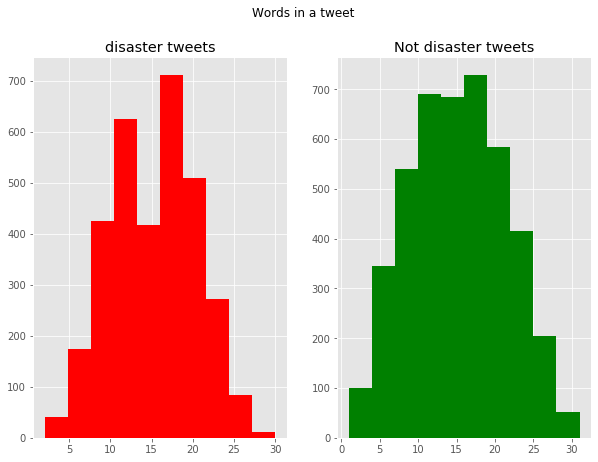

In [11]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,7))
tweet_len=train[train['target']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(tweet_len,color='red')
ax1.set_title('disaster tweets')
tweet_len=train[train['target']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(tweet_len,color='green')
ax2.set_title('Not disaster tweets')
fig.suptitle('Words in a tweet')
plt.show()

Text(0.5, 0.98, 'Average word length in each tweet')

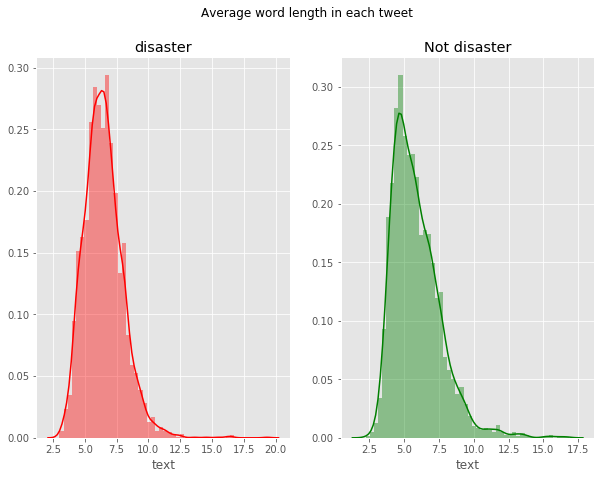

In [12]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,7))
word=train[train['target']==1]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
ax1.set_title('disaster')
word=train[train['target']==0]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='green')
ax2.set_title('Not disaster')
fig.suptitle('Average word length in each tweet')

In [13]:
# Tweets per location

cnt_ = train['location'].value_counts()
cnt_.reset_index()
cnt_ = cnt_[:20,]
trace1 = go.Bar(
                x = cnt_.index,
                y = cnt_.values,
                name = "Number of tweets in dataset according to location",
                marker = dict(color = 'rgba(200, 74, 55, 0.5)',
                             line=dict(color='rgb(0,0,0)',width=1.5)),
                )

data = [trace1]
layout = go.Layout(barmode = "group",title = 'Number of tweets depending on location')
fig = go.Figure(data = data, layout = layout)
py.iplot(fig)

In [14]:
#Number of tweets depending on location per class

train1_df = train[train["target"]==1]
train0_df = train[train["target"]==0]
cnt_1 = train1_df['location'].value_counts()
cnt_1.reset_index()
cnt_1 = cnt_1[:20,]

cnt_0 = train0_df['location'].value_counts()
cnt_0.reset_index()
cnt_0 = cnt_0[:20,]

trace1 = go.Bar(
                x = cnt_1.index,
                y = cnt_1.values,
                name = "Number of real disaster tweets",
                marker = dict(color = 'rgba(255, 74, 55, 0.5)',
                             line=dict(color='rgb(0,0,0)',width=1.5)),
                )
trace0 = go.Bar(
                x = cnt_0.index,
                y = cnt_0.values,
                name = "Number of unreal disaster tweets",
                marker = dict(color = 'rgba(79, 82, 97, 0.5)',
                             line=dict(color='rgb(0,0,0)',width=1.5)),
                )


data = [trace0,trace1]
layout = go.Layout(barmode = 'stack',title = 'Number of tweets depending on location per class')
fig = go.Figure(data = data, layout = layout)
py.iplot(fig)

#### Visualize per location using map

In [15]:
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter


df = train['location'].value_counts()[:20,]
df = pd.DataFrame(df)
df = df.reset_index()
df.columns = ['location', 'counts'] 
geolocator = Nominatim(user_agent="specify_your_app_name_here")
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)
dictt_latitude = {}
dictt_longitude = {}
for i in df['location'].values:
    print(i)
    location = geocode(i)
    dictt_latitude[i] = location.latitude
    dictt_longitude[i] = location.longitude
df['latitude']= df['location'].map(dictt_latitude)
df['longitude'] = df['location'].map(dictt_longitude)

USA
New York
United States
London
Canada
Nigeria
UK
Los Angeles, CA
India


RateLimiter caught an error, retrying (0/2 tries). Called with (*('India',), **{}).
Traceback (most recent call last):
  File "C:\Users\Mahmudur Limon\Anaconda3\envs\gputest\lib\site-packages\geopy\geocoders\base.py", line 355, in _call_geocoder
    page = requester(req, timeout=timeout, **kwargs)
  File "C:\Users\Mahmudur Limon\Anaconda3\envs\gputest\lib\urllib\request.py", line 525, in open
    response = self._open(req, data)
  File "C:\Users\Mahmudur Limon\Anaconda3\envs\gputest\lib\urllib\request.py", line 543, in _open
    '_open', req)
  File "C:\Users\Mahmudur Limon\Anaconda3\envs\gputest\lib\urllib\request.py", line 503, in _call_chain
    result = func(*args)
  File "C:\Users\Mahmudur Limon\Anaconda3\envs\gputest\lib\urllib\request.py", line 1360, in https_open
    context=self._context, check_hostname=self._check_hostname)
  File "C:\Users\Mahmudur Limon\Anaconda3\envs\gputest\lib\urllib\request.py", line 1320, in do_open
    r = h.getresponse()
  File "C:\Users\Mahmudur Lim

Mumbai
Washington, DC
Kenya
Worldwide
Australia
Chicago, IL
California
Everywhere
California, USA
New York, NY
San Francisco


In [16]:
map1 = folium.Map(location=[10.0, 10.0], tiles='CartoDB dark_matter', zoom_start=2.3)
markers = []
for i, row in df.iterrows():
    loss = row['counts']
    if row['counts'] > 0:
        count = row['counts']*0.4
    folium.CircleMarker([float(row['latitude']), float(row['longitude'])], radius=float(count), color='#ef4f61', fill=True).add_to(map1)
map1

It is clear that most of the tweets from america region.

#### Common Stopwords in tweets

In [17]:
def create_corpus(target):
    corpus =[]
    
    for x in train[train['target'] == target]['text'].str.split():
        for i in x:
            corpus.append(i)
            
    return corpus

In [18]:
corpus = create_corpus(1)

In [19]:
dic = defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1
        
top = sorted(dic.items(), key = lambda x:x[1] , reverse = True)[:10] 

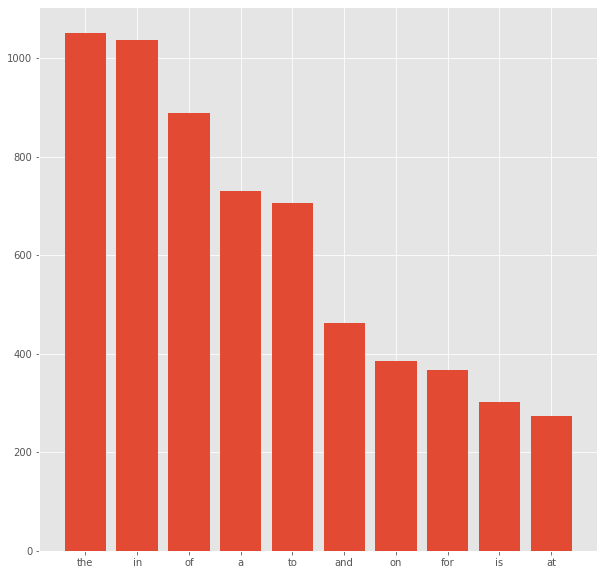

In [20]:
x , y = zip(*top)
plt.figure(figsize = (10 , 10))
plt.bar(x , y);

#### Analyzing Punctuations

<BarContainer object of 18 artists>

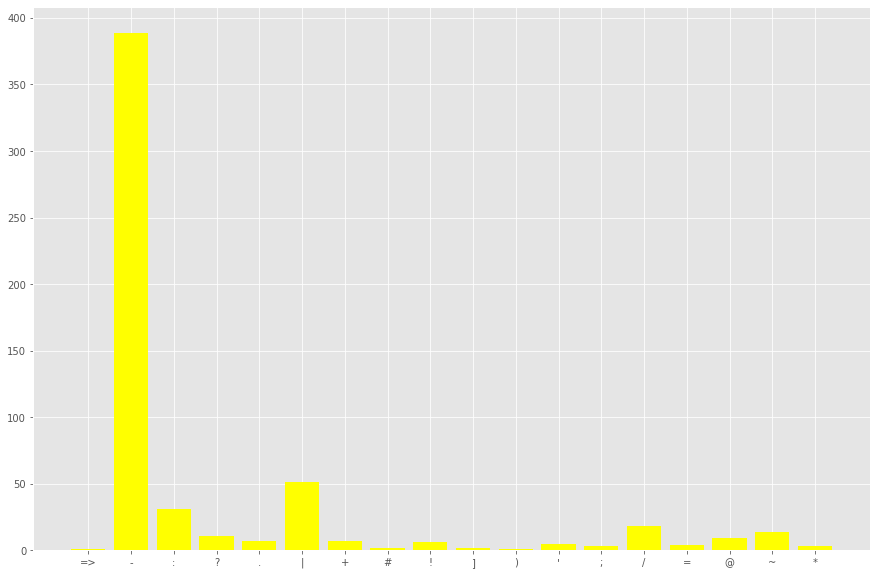

In [21]:
plt.figure(figsize=(15 , 10))

corpus = create_corpus(1)

dic=defaultdict(int)
import string
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1
        
x,y=zip(*dic.items())
plt.bar(x,y , color = 'yellow')

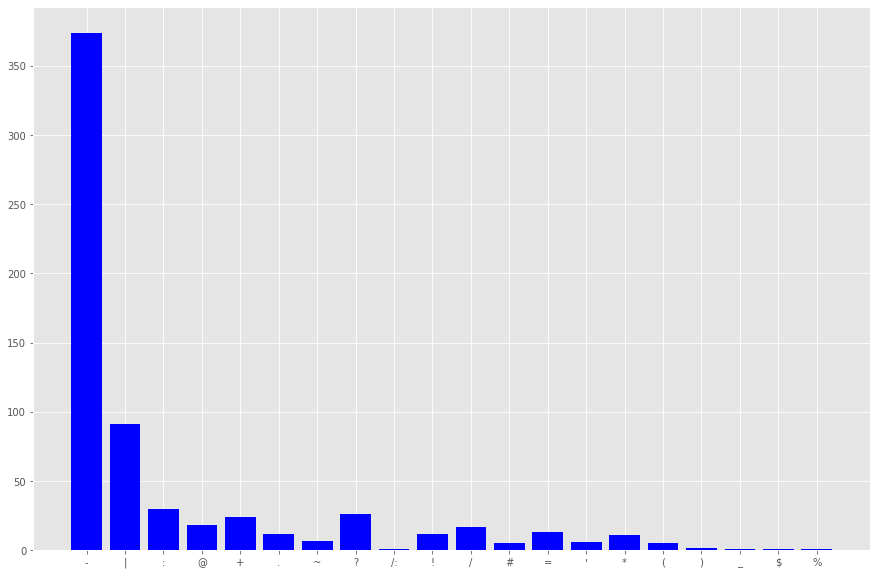

In [22]:
plt.figure(figsize=(15 , 10))
corpus = create_corpus(0)

dic=defaultdict(int)
import string
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1
        
x,y=zip(*dic.items())
plt.bar(x , y , color = 'blue');

#### Common Words

In [23]:
counter=Counter(corpus)
most=counter.most_common()

x=[]
y=[]

for word,count in most[:40]:
    if (word not in stop) :
        x.append(word)
        y.append(count)

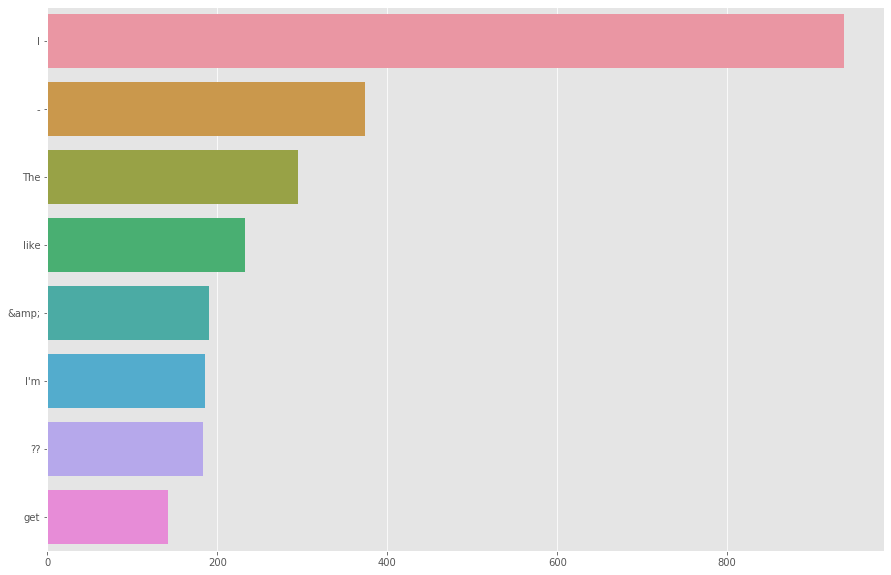

In [24]:
plt.figure(figsize=(15 , 10))
sns.barplot(x = y , y = x);

In [131]:
df = pd.concat([train , test])

## Data Preprocessing

1 . Removing stop words(Optional)

2 . Remove Punctuations

3 . Remove Html

4 . Remove Emojis

5 . Spelling Corrections

6 . Removing Urls

In [195]:
## Concate both train and test part
df_new = pd.concat([train , test])

In [196]:
df_new.shape

(10876, 5)

In [197]:
df_new.isnull().sum()

id             0
keyword       26
location    3638
text           0
target      3263
dtype: int64

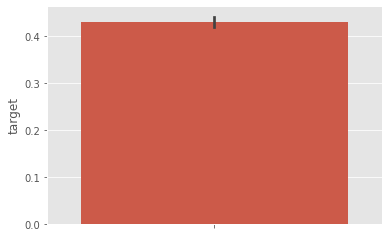

In [198]:
sns.barplot(y = 'target' , data = df_new)

In [199]:
df_new.head(20)

,id,keyword,location,text,target
0,1,No keyword,NaN,Our Deeds are the Reason of this #earthquake M...,1.0
1,4,No keyword,NaN,Forest fire near La Ronge Sask. Canada,1.0
2,5,No keyword,NaN,All residents asked to 'shelter in place' are ...,1.0
3,6,No keyword,NaN,"13,000 people receive #wildfires evacuation or...",1.0
4,7,No keyword,NaN,Just got sent this photo from Ruby #Alaska as ...,1.0
5,8,No keyword,NaN,#RockyFire Update => California Hwy. 20 closed...,1.0
6,10,No keyword,NaN,#flood #disaster Heavy rain causes flash flood...,1.0
7,13,No keyword,NaN,I'm on top of the hill and I can see a fire in...,1.0
8,14,No keyword,NaN,There's an emergency evacuation happening now ...,1.0
9,15,No keyword,NaN,I'm afraid that the tornado is coming to our a...,1.0


In [200]:
df_new.tail()

,id,keyword,location,text,target
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...,NaN
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...,NaN
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...,NaN
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...,NaN
3262,10875,NaN,NaN,#CityofCalgary has activated its Municipal Eme...,NaN


In [201]:
df_new['text'][0]

0    Our Deeds are the Reason of this #earthquake M...
0                   Just happened a terrible car crash
Name: text, dtype: object

In [202]:
df_new['text'][12]

12    #raining #flooding #Florida #TampaBay #Tampa 1...
12                               No don't tell me that!
Name: text, dtype: object

In [203]:
train['text'][0]

'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all'

### Removing URLS

In [204]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

In [205]:
train['text'] = train['text'].apply(lambda x : remove_URL(x))
df_new['text'] = df_new['text'].apply(lambda x : remove_URL(x))
test['text'] = test['text'].apply(lambda x : remove_URL(x))

### Remove HTML tags

In [206]:
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

In [207]:
train['text'] = train['text'].apply(lambda x : remove_html(x))
df_new['text'] = df_new['text'].apply(lambda x : remove_URL(x))
test['text'] = test['text'].apply(lambda x : remove_html(x))

### Remove Emoji's

In [208]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [209]:
df_new['text']=df_new['text'].apply(lambda x: remove_emoji(x))
train['text'] = train['text'].apply(lambda x : remove_emoji(x))
test['text'] = test['text'].apply(lambda x : remove_emoji(x))

In [210]:
df_new['text'][12]

12    #raining #flooding #Florida #TampaBay #Tampa 1...
12                               No don't tell me that!
Name: text, dtype: object

### Remove Punctuations

In [211]:
def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

In [212]:
df_new['text'] = df_new['text'].apply(lambda x : remove_punct(x))
train['text'] = train['text'].apply(lambda x : remove_punct(x))
test['text'] = test['text'].apply(lambda x : remove_punct(x))

In [213]:
df_new['text'][12]

12    raining flooding Florida TampaBay Tampa 18 or ...
12                                 No dont tell me that
Name: text, dtype: object

In [214]:
train['text'][12]

'raining flooding Florida TampaBay Tampa 18 or 19 days Ive lost count '

In [215]:
train.head()

,id,keyword,location,text,target
0,1,No keyword,NaN,Our Deeds are the Reason of this earthquake Ma...,1
1,4,No keyword,NaN,Forest fire near La Ronge Sask Canada,1
2,5,No keyword,NaN,All residents asked to shelter in place are be...,1
3,6,No keyword,NaN,13000 people receive wildfires evacuation orde...,1
4,7,No keyword,NaN,Just got sent this photo from Ruby Alaska as s...,1


In [216]:
train.tail()

,id,keyword,location,text,target
7608,10869,No keyword,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,No keyword,NaN,ariaahrary TheTawniest The out of control wild...,1
7610,10871,No keyword,NaN,M194 0104 UTC5km S of Volcano Hawaii,1
7611,10872,No keyword,NaN,Police investigating after an ebike collided w...,1
7612,10873,No keyword,NaN,The Latest More Homes Razed by Northern Califo...,1


### Spelling corrections

In [217]:
# spell = SpellChecker()
# def correct_spellings(text):
#     corrected_text = []
#     misspelled_words = spell.unknown(text.split())
#     for word in text.split():
#         if word in misspelled_words:
#             corrected_text.append(spell.correction(word))
#         else:
#             corrected_text.append(word)
#     return " ".join(corrected_text)

In [218]:
# df_new['text'] = df_new['text'].apply(lambda x : correct_spellings(x))
# train['text'] = train['text'].apply(lambda x : correct_spellings(x))

In [219]:
train.tail()

,id,keyword,location,text,target
7608,10869,No keyword,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,No keyword,NaN,ariaahrary TheTawniest The out of control wild...,1
7610,10871,No keyword,NaN,M194 0104 UTC5km S of Volcano Hawaii,1
7611,10872,No keyword,NaN,Police investigating after an ebike collided w...,1
7612,10873,No keyword,NaN,The Latest More Homes Razed by Northern Califo...,1


In [220]:
df_new.head()

,id,keyword,location,text,target
0,1,No keyword,NaN,Our Deeds are the Reason of this earthquake Ma...,1.0
1,4,No keyword,NaN,Forest fire near La Ronge Sask Canada,1.0
2,5,No keyword,NaN,All residents asked to shelter in place are be...,1.0
3,6,No keyword,NaN,13000 people receive wildfires evacuation orde...,1.0
4,7,No keyword,NaN,Just got sent this photo from Ruby Alaska as s...,1.0


## Convert Text to TFIDF

In [221]:
x = train.drop(['keyword' , 'location' , 'target'] , axis = 1)
y = train['target']

In [222]:
x

,id,text
0,1,Our Deeds are the Reason of this earthquake Ma...
1,4,Forest fire near La Ronge Sask Canada
2,5,All residents asked to shelter in place are be...
3,6,13000 people receive wildfires evacuation orde...
4,7,Just got sent this photo from Ruby Alaska as s...
...,...,...
7608,10869,Two giant cranes holding a bridge collapse int...
7609,10870,ariaahrary TheTawniest The out of control wild...
7610,10871,M194 0104 UTC5km S of Volcano Hawaii
7611,10872,Police investigating after an ebike collided w...


In [223]:
test

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,Heard about earthquake is different cities sta...
2,3,NaN,NaN,there is a forest fire at spot pond geese are ...
3,9,NaN,NaN,Apocalypse lighting Spokane wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane My citya...
3260,10868,NaN,NaN,Green Line derailment in Chicago
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook HWO


In [225]:
final_test = test.drop(['keyword' , 'location'] , axis = 1)
final_test

,id,text
0,0,Just happened a terrible car crash
1,2,Heard about earthquake is different cities sta...
2,3,there is a forest fire at spot pond geese are ...
3,9,Apocalypse lighting Spokane wildfires
4,11,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...
3258,10861,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,Storm in RI worse than last hurricane My citya...
3260,10868,Green Line derailment in Chicago
3261,10874,MEG issues Hazardous Weather Outlook HWO


In [226]:
final_test.shape

(3263, 2)

In [227]:
x_train , x_test , y_train , y_test = train_test_split(x , y , test_size = 0.20 , random_state = 78)

In [228]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)

(6090, 2)
(1523, 2)
(6090,)


### TFIDF on Text


In [229]:
count_vect = TfidfVectorizer()
X_train_BOW = count_vect.fit_transform(x_train['text'])
X_test_BOW = count_vect.transform(x_test['text'])
test_BOW = count_vect.transform(final_test['text'])

In [230]:
print("**Bow Vectorizer**")
print("="*50)


print(X_train_BOW.shape)
print(X_test_BOW.shape)
print(test_BOW.shape)

**Bow Vectorizer**
(6090, 15510)
(1523, 15510)
(3263, 15510)


In [231]:
X_train_BOW

<6090x15510 sparse matrix of type '<class 'numpy.float64'>'
	with 78145 stored elements in Compressed Sparse Row format>

In [232]:
test_BOW

<3263x15510 sparse matrix of type '<class 'numpy.float64'>'
	with 36702 stored elements in Compressed Sparse Row format>

## Apply DIfferent ML model on TFIDF

## Logistic Regression on TFIDF

In [238]:
#Standardising the train and test data

sc = StandardScaler(copy = True , with_mean = False , with_std = True)
X_train = sc.fit_transform(X_train_BOW)
X_test = sc.transform(X_test_BOW)
Test = sc.transform(test_BOW)

In [239]:
tuned_parameters = [10**-4, 10**-2, 10**0, 10**2, 10**4]

cv_scores = []

for i in tqdm(tuned_parameters):
    model = LogisticRegression(penalty = 'l1' , C = i , n_jobs = -1)
    scores = cross_val_score(model , X_train , y_train , cv = 10 , scoring = 'accuracy' , n_jobs = -1)
    cv_scores.append(scores.mean())

100%|██████████| 5/5 [00:00<00:00,  9.91it/s]


In [240]:
optimal_C = tuned_parameters[cv_scores.index(max(cv_scores))]
print('\nThe optimal value of C is %.3f.' % optimal_C)


The optimal value of C is 0.000.


In [241]:
lr = LogisticRegression(penalty = 'l2' , C = 0.0001 , n_jobs = -1)
lr.fit(X_train , y_train)
pred = lr.predict(X_test)

ac = accuracy_score(y_test , pred)
print(ac*100)

80.03939592908733


In [242]:
# test_pred = lr.predict(Test)

# submission['target'] = test_pred.astype(int)
# submission.to_csv('submission01LR.csv', index=False)

In [243]:
from sklearn import metrics
import scikitplot as skplt

***Test Data Report***
Best C =  0.0001
AUC =  77.1852093494196


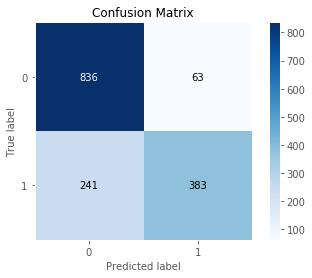

In [244]:
print("***Test Data Report***")
print("Best C = ",optimal_C)
fpr, tpr, threshold = roc_curve(y_test , lr.predict(X_test))
auc = metrics.auc(fpr, tpr)
print("AUC = ",auc*100)
skplt.metrics.plot_confusion_matrix(y_test, pred)
plt.show()

In [0]:
fpr, tpr, threshold = metrics.roc_curve(y_test , lr.predict(X_test))
fpr2, tpr2, threshold2 = metrics.roc_curve(y_test , lr.predict(X_test))

roc_auc = metrics.auc(fpr, tpr)
roc_auc2 = metrics.auc(fpr2, tpr2)

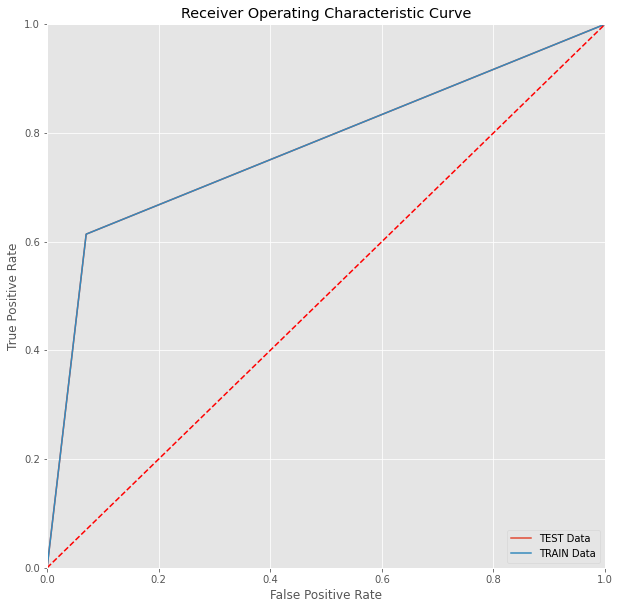

In [135]:
# plot ROC-curve
plt.figure(figsize = (10 , 10))
plt.title('Receiver Operating Characteristic Curve')
plt.gca()
plt.plot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc)
plt.plot(fpr2, tpr2, label = 'AUC = %0.2f' % roc_auc2)
plt.legend(['TEST Data', 'TRAIN Data'],loc = 'lower right')

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [0]:
feature_name = count_vect.get_feature_names()
w = lr.coef_
weight=w.reshape(-1)
sorted_feature = np.argsort(weight)
top_20_positive_feature=sorted_feature[:-20:-1]

In [137]:
print("Positive feature top 20 :")
print("-------")
for i in top_20_positive_feature:
    print("%s\t-->\t%f"%(feature_name[i],weight[i]))

Positive feature top 20 :
-------
in	-->	0.027718
california	-->	0.021282
hiroshima	-->	0.021061
fires	-->	0.018495
killed	-->	0.018091
wildfire	-->	0.017885
suicide	-->	0.017712
fire	-->	0.017127
bombing	-->	0.016577
mh370	-->	0.016244
after	-->	0.014796
northern	-->	0.014695
atomic	-->	0.014491
train	-->	0.014230
homes	-->	0.014214
of	-->	0.014203
bomber	-->	0.014074
pm	-->	0.013985
debris	-->	0.013838


In [0]:
w = lr.coef_
weight=w.reshape(-1)
sorted_feature = np.argsort(weight)
feature_name = count_vect.get_feature_names()
top_20_negative_feature = sorted_feature[:20]

In [139]:
print("Negative feature top 20 :")
print("-------")
for i in top_20_negative_feature:
    print("%s\t -->\t%f  "%(feature_name[i],weight[i]))

Negative feature top 20 :
-------
you	 -->	-0.024945  
my	 -->	-0.020579  
im	 -->	-0.015653  
me	 -->	-0.013220  
just	 -->	-0.013194  
body	 -->	-0.012360  
love	 -->	-0.011911  
your	 -->	-0.010913  
full	 -->	-0.010212  
bags	 -->	-0.009882  
panic	 -->	-0.009731  
harm	 -->	-0.009572  
nowplaying	 -->	-0.009365  
like	 -->	-0.009354  
dont	 -->	-0.009328  
youtube	 -->	-0.009274  
if	 -->	-0.009251  
ruin	 -->	-0.009154  
or	 -->	-0.009101  
blazing	 -->	-0.009021  


In the above list it is clear that there are so many stop words that affects our model.we have to remove the stopwords.

## Apply KNN on TFIDF

In [140]:
knn = KNeighborsClassifier()
knn.fit(X_train , y_train)

y_pred_knn = knn.predict(X_test)

ac = accuracy_score(y_test , y_pred_knn)
print(ac*100)

67.89231779382797


In [0]:
n_folds = 5
parameters = {
        'n_neighbors': range (2 , 50 , 2)
        }


In [142]:
knn = KNeighborsClassifier()

tree = GridSearchCV(estimator = knn , param_grid = parameters , cv = n_folds , n_jobs = -1 , return_train_score = True)
tree.fit(X_train , y_train)

score1 = tree.cv_results_

print(pd.DataFrame(score1).head())
print(tree.best_params_)

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



   mean_fit_time  std_fit_time  ...  mean_train_score  std_train_score
0       0.003554      0.000478  ...          0.719212         0.006467
1       0.003127      0.000575  ...          0.666256         0.004012
2       0.003171      0.000471  ...          0.644376         0.003601
3       0.002999      0.000241  ...          0.634565         0.003533
4       0.003190      0.000352  ...          0.627545         0.005300

[5 rows x 21 columns]
{'n_neighbors': 2}


In [143]:
score1 = pd.DataFrame(score1)
score1.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.003554,0.000478,0.204677,0.024670,2,{'n_neighbors': 2},0.670772,0.667488,0.643678,0.660920,0.651067,0.658785,0.010117,1,0.713259,0.731527,0.714901,0.717365,0.719007,0.719212,0.006467
1,0.003127,0.000575,0.231090,0.005945,4,{'n_neighbors': 4},0.648604,0.648604,0.622332,0.650246,0.635468,0.641051,0.010773,2,0.662562,0.674056,0.665025,0.664409,0.665230,0.666256,0.004012
2,0.003171,0.000471,0.242923,0.014043,6,{'n_neighbors': 6},0.642857,0.637110,0.618227,0.637110,0.626437,0.632348,0.008833,3,0.639984,0.647783,0.647373,0.639984,0.646757,0.644376,0.003601
3,0.002999,0.000241,0.246438,0.014818,8,{'n_neighbors': 8},0.632184,0.628900,0.618227,0.632184,0.621511,0.626601,0.005721,4,0.629926,0.635878,0.639778,0.631363,0.635878,0.634565,0.003533
4,0.003190,0.000352,0.247455,0.016422,10,{'n_neighbors': 10},0.623153,0.623974,0.614943,0.619048,0.620690,0.620361,0.003226,5,0.622126,0.628284,0.634236,0.620895,0.632184,0.627545,0.005300


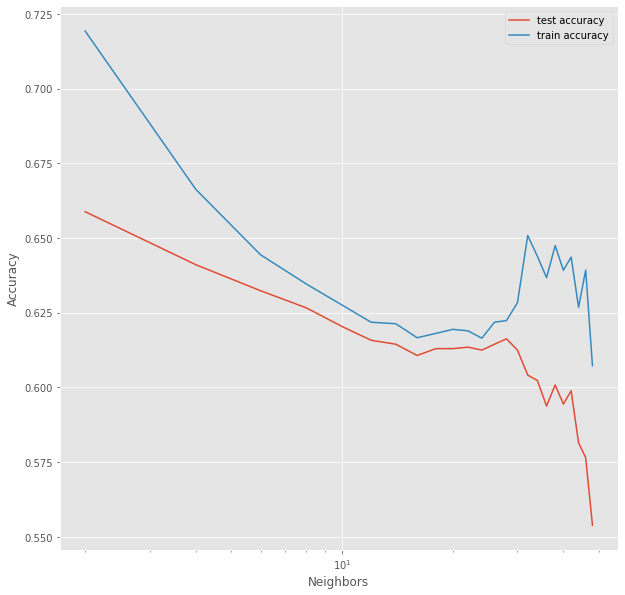

In [144]:
plt.figure(figsize=(10 , 10))
plt.plot(score1['param_n_neighbors'], score1['mean_test_score'])
plt.plot(score1['param_n_neighbors'], score1['mean_train_score'])
plt.xlabel('Neighbors')
plt.ylabel('Accuracy')
plt.legend(['test accuracy', 'train accuracy'] , loc='upper right')
plt.xscale('log')

In [145]:
knn = KNeighborsClassifier(n_neighbors = 2)
knn.fit(X_train , y_train)

y_pred_knn = knn.predict(X_test)

ac_knn = accuracy_score(y_test , y_pred_knn)
print('After Cross-validation: ',ac*100)

After Cross-validation:  67.89231779382797


## Naive-Bayes on TFIDF

In [106]:
alpha = [] 
i = 0.001

while(i <= 1000):
    alpha.append(np.round(i,3))
    i *= 3

cv_scores = []

for k in tqdm(alpha):
    model = MultinomialNB(alpha = k)
    scores = cross_val_score(model , X_train , y_train , cv = 10 , scoring = 'f1_macro' , n_jobs = -1)
    cv_scores.append(scores.mean()) 

100%|██████████| 13/13 [00:03<00:00,  3.77it/s]


In [107]:
optimal_alpha = alpha[cv_scores.index(max(cv_scores))]
print('\nThe optimal value of alpha is %.3f.' % optimal_alpha)


The optimal value of alpha is 531.441.


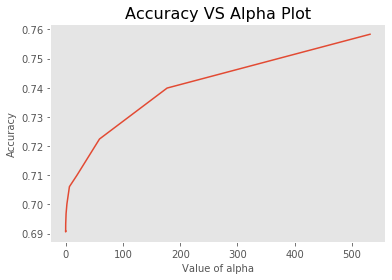


*******Train Data Report******

Alpha values :
 [0.001, 0.003, 0.009, 0.027, 0.081, 0.243, 0.729, 2.187, 6.561, 19.683, 59.049, 177.147, 531.441]

F1 Score for each value of alpha :
  [69.087 69.057 69.13  69.254 69.347 69.42  69.685 70.016 70.609 71.
 72.243 73.991 75.837]


In [108]:
# plot accuracy vs alpha 
plt.plot(alpha, cv_scores)
plt.xlabel('Value of alpha',size=10)
plt.ylabel('Accuracy',size=10)
plt.title('Accuracy VS Alpha Plot',size=16)
plt.grid()
plt.show()
print("\n*******Train Data Report******");
print("\nAlpha values :\n",alpha)
print("\nF1 Score for each value of alpha :\n ", np.round(cv_scores,5)*100)

In [109]:
model_bow_multinomial = MultinomialNB(alpha = optimal_alpha)

model_bow_multinomial.fit(X_train , y_train)

pred = model_bow_multinomial.predict(X_test)

***Test Data Report***
Accuracy =  78.92317793827971
f1_score =  77.88489158515517
precision_score =  78.45958004959232
recall_score =  77.53878953823336


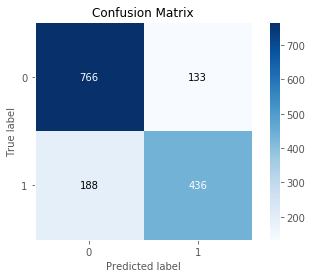

In [110]:
print("***Test Data Report***")
print('Accuracy = ', accuracy_score(y_test, pred)*100)
print("f1_score = ",f1_score(y_test, pred, average='macro')*100)

print("precision_score = " , precision_score(y_test , pred, average='macro')*100)
print("recall_score = " , recall_score(y_test, pred, average='macro')*100)
skplt.metrics.plot_confusion_matrix(y_test, pred)

plt.show()

In [111]:
print(classification_report(y_test , pred))

              precision    recall  f1-score   support

           0       0.80      0.85      0.83       899
           1       0.77      0.70      0.73       624

    accuracy                           0.79      1523
   macro avg       0.78      0.78      0.78      1523
weighted avg       0.79      0.79      0.79      1523



## SVM on TFIDF

In [104]:
sv = SVC()
sv.fit(X_train , y_train)

y_pred_svm = sv.predict(X_test)

ac_svr = accuracy_score(y_test , y_pred_svm)
print(ac_svr*100)

77.28168089297439


In [105]:
# test_pred = sv.predict(Test)

# submission['target'] = test_pred.astype(int)
# submission.to_csv('submission01SVM.csv', index=False)

In [153]:
folds = KFold(n_splits = 5, shuffle = True, random_state = 4)
params = {"C": [0.01 , 0.1, 1, 10, 100, 1000]}

model = SVC()

model_cv_C = GridSearchCV(estimator = model, param_grid = params, cv = folds , verbose = 1 , return_train_score=True , n_jobs = -1)
model_cv_C.fit(X_train, y_train) 


cv_results = pd.DataFrame(model_cv_C.cv_results_)
cv_results

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  2.8min finished


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,5.655618,0.332588,1.171860,0.009045,0.01,{'C': 0.01},0.581281,0.536946,0.574713,0.591133,0.542693,0.565353,0.021570,5,0.561371,0.572455,0.563013,0.558908,0.571018,0.565353,0.005393
1,5.295536,0.064050,1.205936,0.022010,0.1,{'C': 0.1},0.581281,0.536946,0.574713,0.591133,0.542693,0.565353,0.021570,5,0.561371,0.572455,0.563013,0.558908,0.571018,0.565353,0.005393
2,5.215487,0.029133,1.176463,0.017440,1,{'C': 1},0.730706,0.689655,0.738095,0.738095,0.696223,0.718555,0.021191,4,0.974754,0.974138,0.976806,0.973933,0.972906,0.974507,0.001294
3,5.339494,0.020392,1.123487,0.018202,10,{'C': 10},0.741379,0.718391,0.773399,0.761084,0.731527,0.745156,0.019838,1,0.990764,0.990764,0.990969,0.988916,0.989943,0.990271,0.000764
4,5.323694,0.041421,1.110204,0.010157,100,{'C': 100},0.739737,0.718391,0.771757,0.759442,0.729885,0.743842,0.019401,3,0.991174,0.991174,0.991174,0.989327,0.990148,0.990599,0.000750
5,5.297306,0.025804,1.128024,0.023877,1000,{'C': 1000},0.740558,0.720854,0.771757,0.759442,0.729885,0.744499,0.018732,2,0.991174,0.991174,0.991174,0.989327,0.990148,0.990599,0.000750


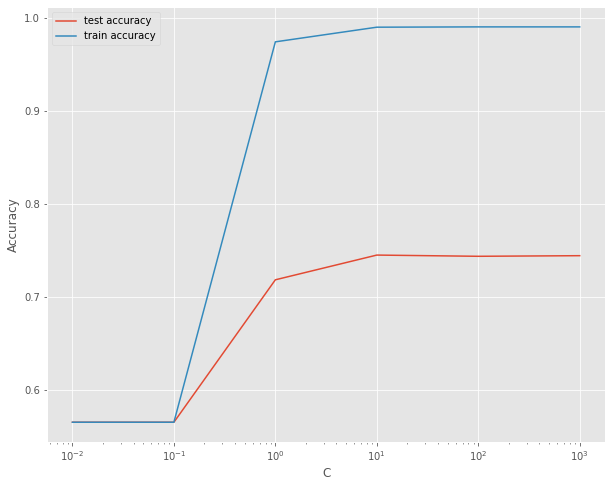

In [154]:
plt.figure(figsize=(10 , 8))
plt.plot(cv_results['param_C'], cv_results['mean_test_score'])
plt.plot(cv_results['param_C'], cv_results['mean_train_score'])
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.legend(['test accuracy', 'train accuracy'], loc='upper left')
plt.xscale('log')

In [155]:
folds = KFold(n_splits = 5, shuffle = True, random_state = 4)
gamma = {'gamma': [1, 0.1, 0.01, 0.001, 0.0001]}

model = SVC()

model_cv_g = GridSearchCV(estimator = model, param_grid = gamma, cv = folds , verbose = 1 , return_train_score=True ,  n_jobs = -1)
model_cv_g.fit(X_train, y_train) 

cv_results_g = pd.DataFrame(model_cv_g.cv_results_)
cv_results_g

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  2.4min finished


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,5.335908,0.062054,1.210324,0.012260,1,{'gamma': 1},0.628900,0.606732,0.629721,0.642036,0.605911,0.622660,0.014131,5,0.991174,0.991174,0.991174,0.989327,0.990148,0.990599,0.000750
1,5.352085,0.045387,1.202844,0.010106,0.1,{'gamma': 0.1},0.628900,0.607553,0.630542,0.642857,0.605911,0.623153,0.014258,4,0.991174,0.991174,0.991174,0.989327,0.990148,0.990599,0.000750
2,5.356799,0.039671,1.191916,0.006707,0.01,{'gamma': 0.01},0.628900,0.609195,0.633005,0.643678,0.605911,0.624138,0.014413,3,0.991174,0.991174,0.991174,0.989327,0.990148,0.990599,0.000750
3,5.421178,0.046521,1.200838,0.028897,0.001,{'gamma': 0.001},0.638752,0.618227,0.652709,0.655172,0.615764,0.636125,0.016611,2,0.990969,0.991174,0.991174,0.989327,0.990148,0.990558,0.000723
4,5.041386,0.574045,1.122797,0.132509,0.0001,{'gamma': 0.0001},0.713465,0.671593,0.724959,0.720854,0.682266,0.702627,0.021569,1,0.983785,0.982553,0.984195,0.981322,0.982759,0.982923,0.001009


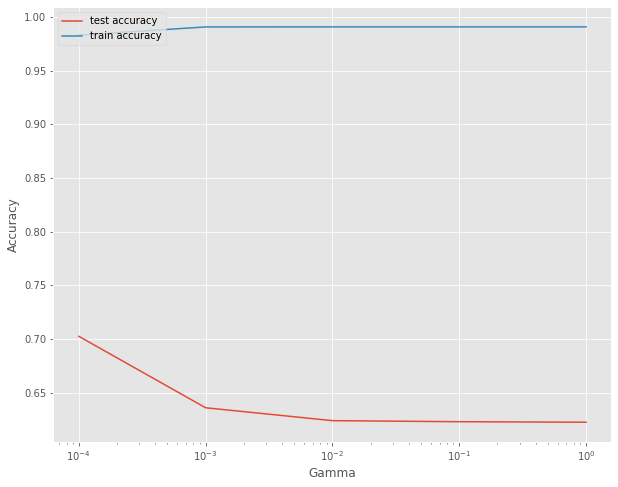

In [156]:
plt.figure(figsize=(10 , 8))
plt.plot(cv_results_g['param_gamma'], cv_results_g['mean_test_score'])
plt.plot(cv_results_g['param_gamma'], cv_results_g['mean_train_score'])
plt.xlabel('Gamma')
plt.ylabel('Accuracy')
plt.legend(['test accuracy', 'train accuracy'], loc='upper left')
plt.xscale('log')

In [157]:
print(model_cv_C.best_params_)
print(model_cv_g.best_params_)

{'C': 10}
{'gamma': 0.0001}


In [84]:
sv = SVC(C = 10 , gamma = 0.0001)
sv.fit(X_train , y_train)

y_pred_svm = sv.predict(X_test)

ac_svr = accuracy_score(y_test , y_pred_svm)
print(ac_svr*100)

75.64018384766908


In [85]:
# test_pred = sv.predict(test_BOW)

# submission['target'] = test_pred.astype(int)
# submission.to_csv('submission01SVM.csv', index=False)

In [112]:
from sklearn import linear_model
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_auc_score

alpha = [10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**3, 10**4]
auc_score=[]


for i in tqdm(alpha):
    model = linear_model.SGDClassifier(alpha=i, loss='hinge', class_weight='balanced')
    model.fit(X_train, y_train)
    
    Cal_CV_model = CalibratedClassifierCV(model , method="sigmoid" , cv = 10)
    Cal_CV_model.fit(X_train, y_train)
    predict_y = Cal_CV_model.predict_proba(X_train)
    preds = predict_y[:,1]
    roc_auc = roc_auc_score(y_train, preds)
    auc_score.append(roc_auc)

100%|██████████| 9/9 [00:02<00:00,  3.59it/s]


In [113]:
# determining best value of alpha
optimal_alpha = alpha[auc_score.index(max(auc_score))]
print('\nThe optimal value of alpha is %.3f.' % optimal_alpha)


The optimal value of alpha is 0.010.


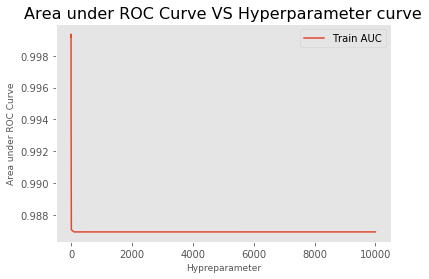

In [114]:
# plot accuracy vs alpha 
plt.plot(alpha, auc_score,label="Train AUC")
plt.xlabel('Hypreparameter',size=9)
plt.ylabel('Area under ROC Curve',size=9)
plt.title('Area under ROC Curve VS Hyperparameter curve',size=16)
plt.legend(loc='best')
plt.grid()
plt.show()

***Test Data Report***
Best alpha =  0.01
AUC =  73.43816847779584


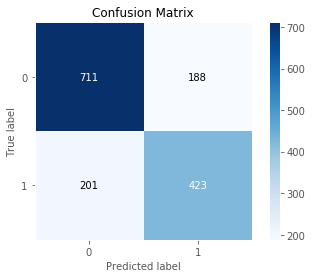

In [115]:
model = linear_model.SGDClassifier(alpha = optimal_alpha, loss='hinge', class_weight='balanced')
model.fit(X_train, y_train)

cc = CalibratedClassifierCV(model, method="sigmoid",cv=10)
cc.fit(X_train, y_train)
pred = cc.predict(X_test)


print("***Test Data Report***")
print("Best alpha = ",optimal_alpha)
fpr, tpr, threshold = metrics.roc_curve(y_test, cc.predict(X_test))
auc = metrics.auc(fpr, tpr)
print("AUC = ",auc*100)
skplt.metrics.plot_confusion_matrix(y_test, pred)
plt.show()

In [116]:
fpr, tpr, threshold = metrics.roc_curve(y_test , model.predict(X_test))
auc = metrics.auc(fpr, tpr)
print("AUC = ",auc*100)

AUC =  72.84054932831351


In [96]:
# test_pred = cc.predict(test_BOW)

# submission['target'] = test_pred.astype(int)
# submission.to_csv('submission01svm.csv', index=False)

## Decision Tree on TFIDF

In [163]:
dt = DecisionTreeClassifier()
dt.fit(X_train , y_train)


y_pred_dt = dt.predict(X_test)

ac = accuracy_score(y_test , y_pred_dt)
print(ac*100)

71.63493105712409


In [164]:
n_folds = 5
parameters = {'min_samples_split': range(20 , 200 , 20)}

dtree = DecisionTreeClassifier(random_state = 100)

tree_split = GridSearchCV(dtree, parameters , cv=n_folds , n_jobs = -1 , return_train_score = True)
tree_split.fit(X_train, y_train)


cv_results_ms = pd.DataFrame(tree_split.cv_results_)
cv_results_ms

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,1.699728,0.158083,0.002029,0.000093,20,{'min_samples_split': 20},0.712644,0.721675,0.708539,0.710181,0.701970,0.711002,0.006402,9,0.943966,0.943555,0.955665,0.946018,0.938834,0.945608,0.005552
1,1.656680,0.210696,0.002123,0.000189,40,{'min_samples_split': 40},0.719212,0.720033,0.714286,0.707718,0.704433,0.713136,0.006179,8,0.919951,0.932677,0.923645,0.928161,0.906814,0.922250,0.008822
2,1.611051,0.209095,0.002186,0.000210,60,{'min_samples_split': 60},0.712644,0.721675,0.715928,0.707718,0.714286,0.714450,0.004539,7,0.908046,0.921182,0.915025,0.922209,0.892857,0.911864,0.010767
3,1.583087,0.189442,0.002007,0.000176,80,{'min_samples_split': 80},0.726601,0.720854,0.716749,0.707718,0.710181,0.716420,0.006900,4,0.910920,0.917693,0.903941,0.914204,0.884647,0.906281,0.011731
4,1.572444,0.177778,0.002090,0.000192,100,{'min_samples_split': 100},0.725780,0.724138,0.712644,0.704433,0.715107,0.716420,0.007834,5,0.905993,0.906199,0.899425,0.910714,0.880542,0.900575,0.010644
5,1.573703,0.169314,0.002040,0.000220,120,{'min_samples_split': 120},0.717570,0.722496,0.717570,0.715107,0.714286,0.717406,0.002863,2,0.899631,0.900452,0.893473,0.907020,0.881979,0.896511,0.008439
6,1.585766,0.168655,0.002055,0.000087,140,{'min_samples_split': 140},0.718391,0.719212,0.717570,0.715107,0.711002,0.716256,0.002965,6,0.895936,0.899220,0.892652,0.907020,0.881773,0.895320,0.008284
7,1.596000,0.205946,0.002152,0.000202,160,{'min_samples_split': 160},0.719212,0.719212,0.718391,0.717570,0.711823,0.717241,0.002777,3,0.895115,0.899220,0.887521,0.903736,0.878079,0.892734,0.009063
8,1.478194,0.289144,0.002115,0.000370,180,{'min_samples_split': 180},0.723317,0.723317,0.711823,0.717570,0.719212,0.719048,0.004263,1,0.892036,0.899220,0.878695,0.903736,0.873563,0.889450,0.011613


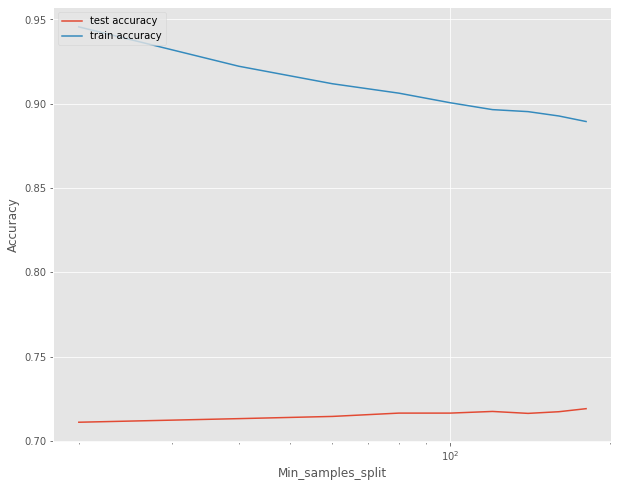

In [165]:
plt.figure(figsize=(10 , 8))
plt.plot(cv_results_ms['param_min_samples_split'] , cv_results_ms['mean_test_score'])
plt.plot(cv_results_ms['param_min_samples_split'] , cv_results_ms['mean_train_score'])
plt.xlabel('Min_samples_split')
plt.ylabel('Accuracy')
plt.legend(['test accuracy', 'train accuracy'], loc='upper left')
plt.xscale('log')

In [166]:
n_folds = 5
parameters = {'min_samples_leaf': range (1 , 20)}

dtree = DecisionTreeClassifier()

tree_ml = GridSearchCV(dtree , parameters , cv=n_folds , n_jobs = -1 , return_train_score = True)
tree_ml.fit(X_train, y_train)


cv_results_ml = pd.DataFrame(tree_ml.cv_results_)
cv_results_ml

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,1.893599,0.225735,0.002155,0.000255,1,{'min_samples_leaf': 1},0.702791,0.727422,0.701970,0.705255,0.701970,0.707882,0.009844,1,0.990969,0.991995,0.989532,0.990558,0.989943,0.990599,0.000855
1,1.557385,0.129699,0.001954,0.000175,2,{'min_samples_leaf': 2},0.690476,0.724138,0.715928,0.694581,0.692939,0.703612,0.013719,5,0.928777,0.930213,0.927545,0.931650,0.925903,0.928818,0.002004
2,1.328296,0.115199,0.001935,0.000096,3,{'min_samples_leaf': 3},0.694581,0.689655,0.702791,0.677340,0.681445,0.689163,0.009107,11,0.897373,0.895115,0.895320,0.898604,0.896757,0.896634,0.001302
3,1.097249,0.095543,0.001898,0.000067,4,{'min_samples_leaf': 4},0.700328,0.697044,0.701970,0.674877,0.697044,0.694253,0.009874,7,0.863711,0.865969,0.860632,0.865764,0.864122,0.864039,0.001919
4,0.993719,0.099342,0.001764,0.000078,5,{'min_samples_leaf': 5},0.715928,0.704433,0.720854,0.692939,0.702791,0.707389,0.009929,2,0.849138,0.853038,0.848522,0.850164,0.848933,0.849959,0.001632
5,0.877306,0.061906,0.001733,0.000061,6,{'min_samples_leaf': 6},0.714286,0.700328,0.711823,0.697865,0.706897,0.706240,0.006347,3,0.834565,0.836002,0.835181,0.833333,0.831281,0.834072,0.001645
6,0.789357,0.031977,0.001730,0.000096,7,{'min_samples_leaf': 7},0.703612,0.706897,0.698686,0.703612,0.711002,0.704762,0.004075,4,0.823686,0.826149,0.821018,0.823276,0.822250,0.823276,0.001707
7,0.742911,0.044971,0.001860,0.000097,8,{'min_samples_leaf': 8},0.706897,0.691297,0.701149,0.676519,0.696223,0.694417,0.010338,6,0.811576,0.815476,0.818144,0.809934,0.809729,0.812972,0.003308
8,0.683626,0.042113,0.001747,0.000189,9,{'min_samples_leaf': 9},0.706076,0.694581,0.691297,0.668309,0.693760,0.690805,0.012349,10,0.803366,0.809729,0.801519,0.799877,0.803161,0.803530,0.003346
9,0.677746,0.050152,0.001670,0.000087,10,{'min_samples_leaf': 10},0.697865,0.685550,0.699507,0.667488,0.709360,0.691954,0.014384,9,0.795567,0.802340,0.797003,0.791667,0.795361,0.796388,0.003459


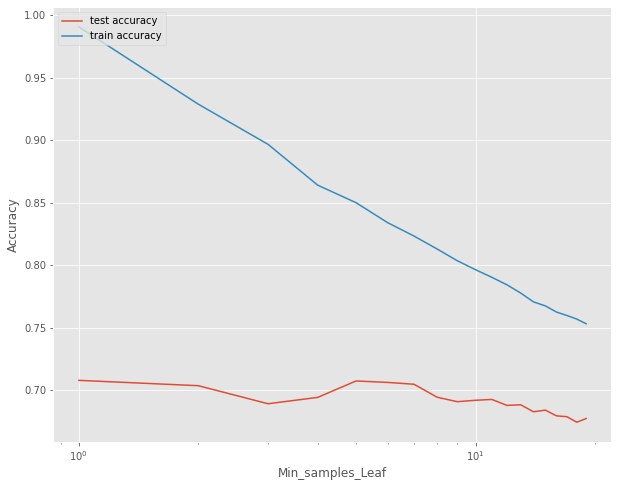

In [167]:
plt.figure(figsize=(10 , 8))
plt.plot(cv_results_ml['param_min_samples_leaf'] , cv_results_ml['mean_test_score'])
plt.plot(cv_results_ml['param_min_samples_leaf'] , cv_results_ml['mean_train_score'])
plt.xlabel('Min_samples_Leaf')
plt.ylabel('Accuracy')
plt.legend(['test accuracy', 'train accuracy'], loc='upper left')
plt.xscale('log')

In [168]:
n_folds = 5
parameters = {'max_depth':range (1,20)}

dtree = DecisionTreeClassifier()

tree_d = GridSearchCV(dtree , parameters , cv=n_folds , n_jobs = -1 , return_train_score = True)
tree_d.fit(X_train, y_train)


cv_results_d = pd.DataFrame(tree_d.cv_results_)
cv_results_d

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.117838,0.006036,0.001381,0.000090,1,{'max_depth': 1},0.613300,0.618227,0.610016,0.604269,0.590312,0.607225,0.009597,19,0.605911,0.605090,0.606938,0.608580,0.612069,0.607718,0.002468
1,0.124817,0.003318,0.001163,0.000027,2,{'max_depth': 2},0.614122,0.621511,0.610837,0.606732,0.600164,0.610673,0.007146,18,0.611864,0.610427,0.613300,0.614122,0.627463,0.615435,0.006145
2,0.138048,0.003121,0.001219,0.000114,3,{'max_depth': 3},0.616585,0.637931,0.615764,0.614122,0.611658,0.619212,0.009510,17,0.617406,0.626232,0.628079,0.620074,0.642036,0.626765,0.008574
3,0.157922,0.008314,0.001322,0.000101,4,{'max_depth': 4},0.627258,0.645320,0.623974,0.626437,0.622332,0.629064,0.008315,16,0.629721,0.641010,0.640805,0.633005,0.655378,0.639984,0.008863
4,0.168426,0.008838,0.001273,0.000145,5,{'max_depth': 5},0.635468,0.655993,0.640394,0.637110,0.623153,0.638424,0.010547,15,0.645320,0.653941,0.656814,0.649015,0.658251,0.652668,0.004844
5,0.185400,0.009045,0.001336,0.000108,6,{'max_depth': 6},0.638752,0.655172,0.640394,0.644499,0.625616,0.640887,0.009541,14,0.662972,0.658046,0.661330,0.659893,0.661330,0.660714,0.001652
6,0.196662,0.007864,0.001212,0.000044,7,{'max_depth': 7},0.648604,0.662562,0.651067,0.646962,0.635468,0.648933,0.008667,13,0.675903,0.672414,0.676108,0.674877,0.674056,0.674672,0.001349
7,0.214367,0.009689,0.001311,0.000069,8,{'max_depth': 8},0.654351,0.669130,0.649425,0.662562,0.640394,0.655172,0.010015,12,0.686987,0.686166,0.691913,0.688424,0.682266,0.687151,0.003135
8,0.229419,0.002863,0.001269,0.000040,9,{'max_depth': 9},0.660099,0.666667,0.655172,0.665025,0.637931,0.656979,0.010338,11,0.694992,0.697250,0.703612,0.700123,0.694376,0.698071,0.003427
9,0.249264,0.006202,0.001378,0.000088,10,{'max_depth': 10},0.662562,0.676519,0.656814,0.666667,0.655993,0.663711,0.007500,10,0.703407,0.707307,0.713259,0.709565,0.707102,0.708128,0.003238


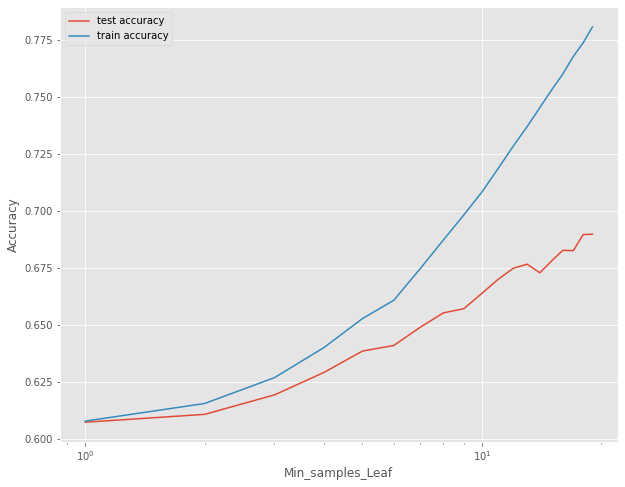

In [169]:
plt.figure(figsize=(10 , 8))
plt.plot(cv_results_d['param_max_depth'] , cv_results_d['mean_test_score'])
plt.plot(cv_results_d['param_max_depth'] , cv_results_d['mean_train_score'])
plt.xlabel('Min_samples_Leaf')
plt.ylabel('Accuracy')
plt.legend(['test accuracy', 'train accuracy'], loc='upper left')
plt.xscale('log')

In [170]:
print(tree_split.best_params_)
print(tree_ml.best_params_)
print(tree_d.best_params_)

{'min_samples_split': 180}
{'min_samples_leaf': 1}
{'max_depth': 19}


In [171]:
dt = DecisionTreeClassifier(max_depth = 19 , min_samples_leaf = 1 , min_samples_split = 180)
dt.fit(X_train , y_train)


y_pred_dt = dt.predict(X_test)

ac = accuracy_score(y_test , y_pred_dt)
print(ac*100)

70.78135259356533


***Test Data Report***
Best max_depth =  20
Best min_samples_split =  80
AUC =  73.58710533070933


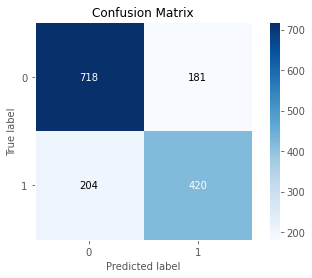

In [172]:
optimal_depth = 20
optimal_split = 80

print("***Test Data Report***")
print("Best max_depth = ",optimal_depth)
print("Best min_samples_split = ",optimal_split)
fpr, tpr, threshold = metrics.roc_curve(y_test, lr.predict(X_test))
auc = metrics.auc(fpr, tpr)
print("AUC = ",auc*100)
skplt.metrics.plot_confusion_matrix(y_test, pred)
plt.show()

## Random Forest on TFIDF

In [97]:
max_depths = [2,4,6,9,11]
base_learners = [1, 5, 10, 50, 100]
param_grid = {'max_depth': max_depths,'n_estimators':base_learners}


model = GridSearchCV(RandomForestClassifier(class_weight='balanced'), param_grid, scoring = 'roc_auc', cv=3 , n_jobs = -1 , return_train_score = True)
model.fit(X_train, y_train)

print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(X_train, y_train))

Model with best parameters :
 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=11, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
Accuracy of the model :  0.8897789363854389


In [98]:
y_pred_rf = model.predict(X_test)
ac = accuracy_score(y_test , y_pred_rf)
ac

0.7721602101116218

In [101]:
# test_pred = model.predict(test_BOW)

# submission['target'] = test_pred.astype(int)
# submission.to_csv('submission01rf.csv', index=False)

In [175]:
dataframe = pd.DataFrame(model.cv_results_)
dataframe.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0.010372,0.000400,0.003838,0.000035,2,1,"{'max_depth': 2, 'n_estimators': 1}",0.510617,0.512330,0.500565,0.507837,0.005190,25,0.511684,0.521549,0.506343,0.513192,0.006299
1,0.021819,0.000283,0.004742,0.000343,2,5,"{'max_depth': 2, 'n_estimators': 5}",0.569959,0.536298,0.567981,0.558080,0.015423,20,0.569574,0.537779,0.573396,0.560250,0.015966
2,0.038920,0.000237,0.006520,0.000330,2,10,"{'max_depth': 2, 'n_estimators': 10}",0.581464,0.589765,0.579737,0.583655,0.004377,18,0.600877,0.623548,0.600416,0.608280,0.010797
3,0.174336,0.001871,0.019783,0.000966,2,50,"{'max_depth': 2, 'n_estimators': 50}",0.731064,0.706284,0.712944,0.716764,0.010471,11,0.770766,0.770906,0.765375,0.769016,0.002575
4,0.353125,0.012580,0.038254,0.002772,2,100,"{'max_depth': 2, 'n_estimators': 100}",0.759094,0.740226,0.769898,0.756406,0.012262,8,0.814151,0.815409,0.820305,0.816622,0.002655


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



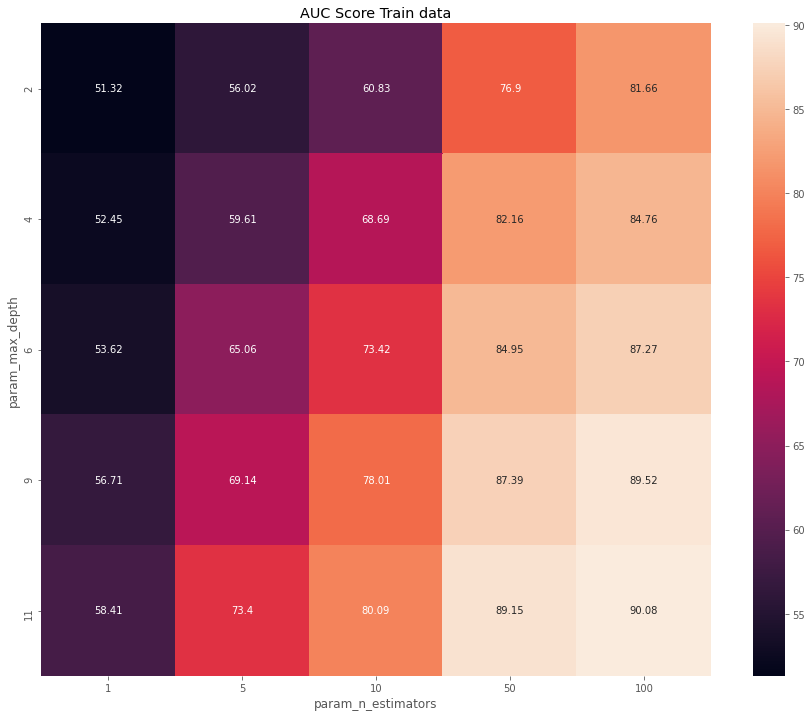

In [176]:
# Train Data Auc Score Vs hyperparameter Heatmap
max_scores = dataframe.groupby(['param_max_depth', 
                                    'param_n_estimators']).max()
max_scores = max_scores.unstack()[['mean_test_score', 'mean_train_score']]
plt.figure(figsize = (15 , 12))
sns.heatmap(max_scores.mean_train_score*100, annot=True, fmt='.4g');
ax = plt.axes()
ax.set_title('AUC Score Train data')
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



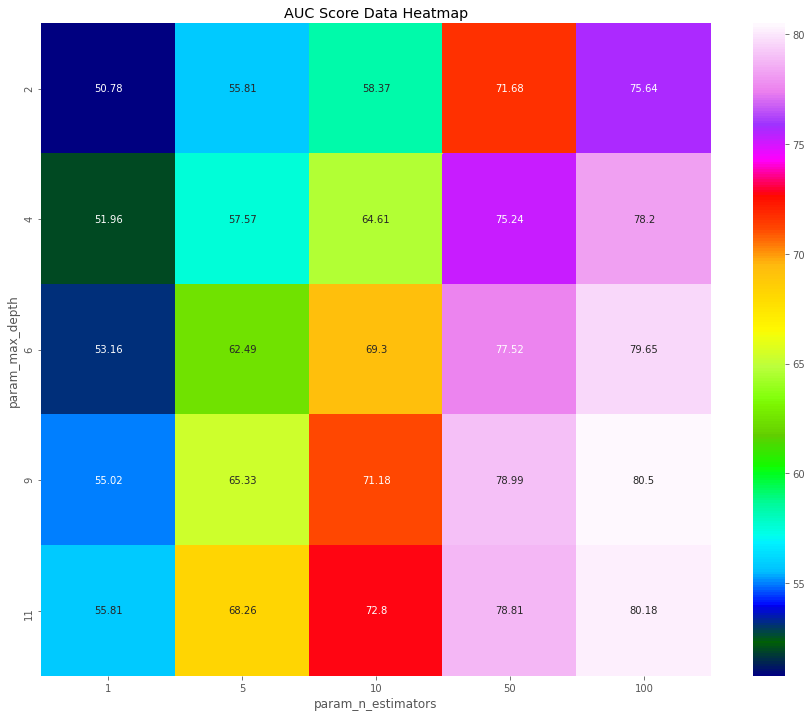

In [177]:
# CV Data Auc Score Vs hyperparameter Heatmap
max_scores = dataframe.groupby(['param_max_depth', 
                                    'param_n_estimators']).max()
max_scores = max_scores.unstack()[['mean_test_score', 'mean_train_score']]
plt.figure(figsize = (15 , 12))
sns.heatmap(max_scores.mean_test_score*100, annot=True, fmt='.4g' , cmap = 'gist_ncar')
ax = plt.axes()
ax.set_title('AUC Score Data Heatmap')
plt.show()

***Test Data Report***
Best max_depth =  11
Best Base Learners =  100
AUC =  74.08097672627706


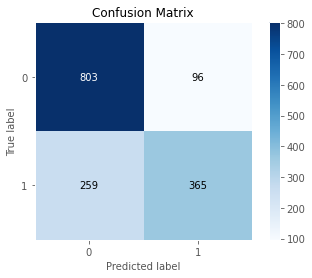

In [178]:
optimal_depth = 11
optimal_estimators = 100

lr = RandomForestClassifier(n_estimators=optimal_estimators, max_depth=optimal_depth, class_weight='balanced')
lr.fit(X_train_BOW,y_train)
pred = lr.predict(X_test_BOW)

print("***Test Data Report***")
print("Best max_depth = ",optimal_depth)
print("Best Base Learners = ",optimal_estimators)
fpr, tpr, threshold = metrics.roc_curve(y_test, lr.predict(X_test))
auc = metrics.auc(fpr, tpr)
print("AUC = ",auc*100)
skplt.metrics.plot_confusion_matrix(y_test, pred)
plt.show()

In [179]:
rf = RandomForestClassifier()
rf.fit(X_train , y_train)

y_pred_rf = rf.predict(X_test)

ac_rf = accuracy_score(y_test , y_pred_rf)
print(ac_rf*100)

80.3676953381484


In [0]:
test_pred = rf.predict(test_BOW)

In [0]:
# test_pred = rf.predict(test_BOW)
# submission['target'] = test_pred.astype(int)
# submission.to_csv('submission02.csv', index=False)

In [182]:
n_folds = 10
parameters = {'max_depth': range(2, 30, 2)}

rf = RandomForestClassifier(random_state = 100)
grd_search_max = GridSearchCV(rf , parameters , cv = n_folds , n_jobs = -1 , return_train_score = True)

grd_search_max.fit(X_train , y_train)
print('Best parameter for max_depth: ',grd_search_max.best_params_)

scores = grd_search_max.cv_results_
pd.DataFrame(scores).head()

Best parameter for max_depth:  {'max_depth': 28}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.424377,0.008111,0.022689,0.002967,2,{'max_depth': 2},0.568144,0.568144,0.569787,0.571429,0.564860,0.569787,0.571429,0.564860,0.564860,0.568144,0.568144,0.002436,14,0.569057,0.567597,0.569057,0.571611,0.565590,0.569969,0.568874,0.568144,0.565408,0.569239,0.568455,0.001791
1,0.585869,0.010512,0.021331,0.003175,4,{'max_depth': 4},0.581281,0.599343,0.584565,0.586207,0.582923,0.579639,0.584565,0.576355,0.581281,0.591133,0.584729,0.006164,13,0.583653,0.596059,0.590768,0.588396,0.586024,0.590951,0.584747,0.591498,0.588944,0.588214,0.588925,0.003456
2,0.781227,0.005976,0.020747,0.002624,6,{'max_depth': 6},0.609195,0.612479,0.607553,0.614122,0.607553,0.599343,0.612479,0.594417,0.597701,0.615764,0.607061,0.007045,12,0.609925,0.619595,0.617588,0.618318,0.613209,0.618500,0.605364,0.610837,0.612297,0.612479,0.613811,0.004356
3,0.994372,0.018424,0.020279,0.001904,8,{'max_depth': 8},0.638752,0.637110,0.615764,0.630542,0.627258,0.625616,0.635468,0.619048,0.612479,0.630542,0.627258,0.008595,11,0.631454,0.638935,0.630724,0.639847,0.634191,0.636015,0.629995,0.629630,0.633279,0.636928,0.634100,0.003521
4,1.201812,0.019646,0.020090,0.001953,10,{'max_depth': 10},0.658456,0.653530,0.635468,0.638752,0.632184,0.635468,0.660099,0.642036,0.625616,0.645320,0.642693,0.010946,10,0.654260,0.660828,0.651706,0.661376,0.649334,0.658456,0.650976,0.651159,0.652436,0.661011,0.655154,0.004511


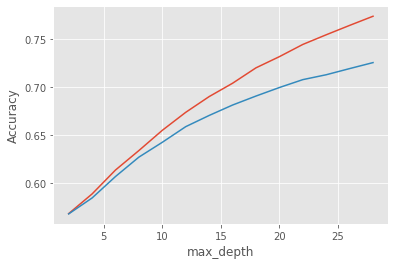

In [183]:
plt.figure()
plt.plot(scores["param_max_depth"],scores["mean_train_score"],label="Training accuracy")
plt.plot(scores["param_max_depth"],scores["mean_test_score"],label="Test accuracy")
plt.xlabel('max_depth')
plt.ylabel('Accuracy')
plt.show()


In [184]:
n_folds = 5
parameters = {'n_estimators': range(50, 500, 50)}

rf = RandomForestClassifier(random_state = 100)
grd_search_est = GridSearchCV(rf , parameters , cv = n_folds , n_jobs = -1 , return_train_score = True)

grd_search_est.fit(X_train, y_train)
print('Best parameter for n_estimators: ',grd_search_est.best_params_)

scores_1 = grd_search_est.cv_results_
pd.DataFrame(scores_1).head()

Best parameter for n_estimators:  {'n_estimators': 200}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,8.099913,0.176430,0.057988,0.005534,50,{'n_estimators': 50},0.778325,0.772578,0.778325,0.763547,0.785714,0.775698,0.007369,9,0.989943,0.991174,0.989122,0.989943,0.989737,0.989984,0.000667
1,16.092455,0.244229,0.107719,0.001105,100,{'n_estimators': 100},0.788998,0.773399,0.777504,0.763547,0.784893,0.777668,0.008925,7,0.990764,0.991790,0.989122,0.990353,0.989943,0.990394,0.000884
2,24.010827,0.476096,0.161351,0.003216,150,{'n_estimators': 150},0.784893,0.775041,0.777504,0.772578,0.788998,0.779803,0.006175,2,0.990969,0.991995,0.989532,0.990558,0.989943,0.990599,0.000855
3,31.958052,0.666247,0.213921,0.003433,200,{'n_estimators': 200},0.786535,0.778325,0.781609,0.770115,0.789819,0.781281,0.006842,1,0.990969,0.991995,0.989532,0.990558,0.989943,0.990599,0.000855
4,39.964612,0.698313,0.270888,0.006706,250,{'n_estimators': 250},0.788177,0.775041,0.779146,0.768473,0.784893,0.779146,0.007005,3,0.990969,0.991995,0.989532,0.990558,0.989943,0.990599,0.000855


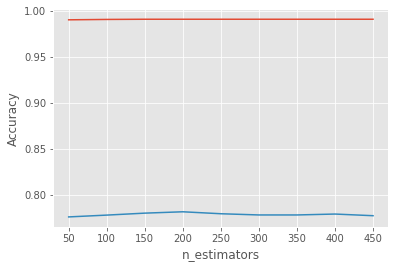

In [185]:
plt.figure()
plt.plot(scores_1["param_n_estimators"],scores_1["mean_train_score"],label="Training accuracy")
plt.plot(scores_1["param_n_estimators"],scores_1["mean_test_score"],label="Test accuracy")
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')
plt.show()

In [186]:
n_folds = 5
parameters = {'min_samples_leaf': range(30, 400, 50)}

rf = RandomForestClassifier(random_state = 100)
grd_search_lf = GridSearchCV(rf , parameters , cv = n_folds , return_train_score = True)

grd_search_lf.fit(X_train, y_train)
print('Best parameter for min_samples_leaf: ',grd_search_lf.best_params_)

scores_2 = grd_search_lf.cv_results_
pd.DataFrame(scores_2).head()

Best parameter for min_samples_leaf:  {'min_samples_leaf': 30}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.258735,0.008364,0.015057,0.000183,30,{'min_samples_leaf': 30},0.565681,0.565681,0.565681,0.56486,0.56486,0.565353,0.000402,1,0.565271,0.565271,0.565271,0.565476,0.565476,0.565353,0.000101
1,0.201999,0.009192,0.015869,0.001319,80,{'min_samples_leaf': 80},0.565681,0.565681,0.565681,0.56486,0.56486,0.565353,0.000402,1,0.565271,0.565271,0.565271,0.565476,0.565476,0.565353,0.000101
2,0.187009,0.002932,0.014836,0.000285,130,{'min_samples_leaf': 130},0.565681,0.565681,0.565681,0.56486,0.56486,0.565353,0.000402,1,0.565271,0.565271,0.565271,0.565476,0.565476,0.565353,0.000101
3,0.183977,0.002477,0.014899,0.000217,180,{'min_samples_leaf': 180},0.565681,0.565681,0.565681,0.56486,0.56486,0.565353,0.000402,1,0.565271,0.565271,0.565271,0.565476,0.565476,0.565353,0.000101
4,0.182156,0.003660,0.014706,0.000298,230,{'min_samples_leaf': 230},0.565681,0.565681,0.565681,0.56486,0.56486,0.565353,0.000402,1,0.565271,0.565271,0.565271,0.565476,0.565476,0.565353,0.000101


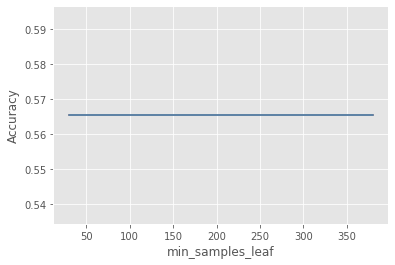

In [187]:
plt.figure()
plt.plot(scores_2["param_min_samples_leaf"],scores_2["mean_train_score"],label="Training accuracy")
plt.plot(scores_2["param_min_samples_leaf"],scores_2["mean_test_score"],label="Test accuracy")
plt.xlabel('min_samples_leaf')
plt.ylabel('Accuracy')
plt.show()

In [188]:
n_folds = 5
parameters = {'min_samples_split': range(10, 400, 50)}

rf = RandomForestClassifier()
grd_search_sp = GridSearchCV(rf , parameters , cv = n_folds , n_jobs = -1, return_train_score = True)

grd_search_sp.fit(X_train, y_train)
print('Best parameter for min_samples_split: ',grd_search_sp.best_params_)

score_3 = grd_search_sp.cv_results_
pd.DataFrame(score_3).head()

Best parameter for min_samples_split:  {'min_samples_split': 160}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,11.052841,0.125699,0.107336,0.006415,10,{'min_samples_split': 10},0.784072,0.776683,0.772578,0.772578,0.779146,0.777011,0.004332,8,0.987069,0.986658,0.985222,0.985222,0.984401,0.985714,0.000994
1,9.897639,0.098802,0.101168,0.007127,60,{'min_samples_split': 60},0.789819,0.773399,0.772578,0.776683,0.782430,0.778982,0.006431,7,0.967159,0.969417,0.969007,0.966544,0.967775,0.967980,0.001086
2,9.583246,0.067716,0.094797,0.000959,110,{'min_samples_split': 110},0.791461,0.784072,0.785714,0.775862,0.783251,0.784072,0.005008,3,0.957307,0.955460,0.956486,0.955049,0.950944,0.955049,0.002199
3,9.323498,0.117283,0.097516,0.001353,160,{'min_samples_split': 160},0.791461,0.782430,0.779146,0.785714,0.791461,0.786043,0.004888,1,0.944376,0.944787,0.944376,0.945608,0.940476,0.943924,0.001782
4,9.211862,0.172331,0.095491,0.005319,210,{'min_samples_split': 210},0.781609,0.781609,0.779967,0.780788,0.778325,0.780460,0.001229,5,0.938629,0.942118,0.939450,0.934934,0.934729,0.937972,0.002813


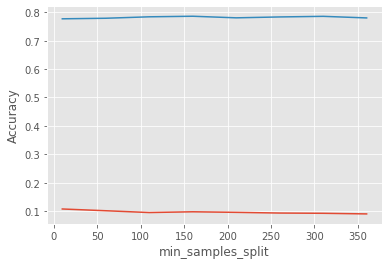

In [189]:
plt.figure()
plt.plot(score_3["param_min_samples_split"],score_3["mean_score_time"],label="Training accuracy")
plt.plot(score_3["param_min_samples_split"],score_3["mean_test_score"],label="Test accuracy")
plt.xlabel('min_samples_split')
plt.ylabel('Accuracy')
plt.show()

In [190]:
print('Best parameter for max_depth: ',grd_search_max.best_params_)
print('Best parameter for min_samples_leaf: ',grd_search_lf.best_params_)
print('Best parameter for min_samples_split: ',grd_search_sp.best_params_)
print('Best parameter for n_estimators: ',grd_search_est.best_params_)

Best parameter for max_depth:  {'max_depth': 28}
Best parameter for min_samples_leaf:  {'min_samples_leaf': 30}
Best parameter for min_samples_split:  {'min_samples_split': 160}
Best parameter for n_estimators:  {'n_estimators': 200}


In [191]:
new_rf = RandomForestClassifier(n_estimators = 200 , max_depth = 28 , min_samples_leaf = 30 , min_samples_split = 160)
new_rf.fit(X_train , y_train)

y_pred_rf = new_rf.predict(X_test)

ac_rf = accuracy_score(y_test , y_pred_rf)
print(ac_rf*100)

59.42219304005253


## GBDT on TFIDF

In [0]:
learn_rate = {'learning_rate': [0.001 , 0.01 , 0.1 , 1.0 , 1.3]}
folds = 5

In [193]:
GBC = GradientBoostingClassifier()

grd_search_lr = GridSearchCV(GBC , cv = folds , param_grid = learn_rate , n_jobs = -1)
grd_search_lr.fit(X_train, y_train)
print('Best parameter for max_depth: ' , grd_search_lr.best_params_)

cv_results_gbdt = pd.DataFrame(grd_search_lr.cv_results_)
cv_results_gbdt.head()

Best parameter for max_depth:  {'learning_rate': 1.0}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,13.134242,0.174235,0.003427,0.000163,0.001,{'learning_rate': 0.001},0.565681,0.565681,0.565681,0.564860,0.564860,0.565353,0.000402,5
1,12.994349,0.097355,0.003668,0.000228,0.01,{'learning_rate': 0.01},0.666667,0.650246,0.646962,0.661741,0.631363,0.651396,0.012349,4
2,13.018176,0.176694,0.003660,0.000127,0.1,{'learning_rate': 0.1},0.738095,0.724959,0.744663,0.727422,0.730706,0.733169,0.007251,3
3,12.875700,0.081057,0.003707,0.000154,1,{'learning_rate': 1.0},0.747947,0.743021,0.737274,0.746305,0.740558,0.743021,0.003851,1
4,11.818944,2.427108,0.003474,0.000625,1.3,{'learning_rate': 1.3},0.759442,0.733169,0.734811,0.744663,0.736453,0.741708,0.009709,2


In [0]:
sub_sample = {"subsample": [0.3, 0.6, 0.9]}
folds = 5

In [195]:
GBC = GradientBoostingClassifier(max_depth=2, n_estimators=200)

grd_search_ss = GridSearchCV(GBC , cv = folds , param_grid = sub_sample)
grd_search_ss.fit(X_train, y_train)
print('Best parameter for max_depth: ',grd_search_ss.best_params_)

cv_results_sub = pd.DataFrame(grd_search_lr.cv_results_)
cv_results_sub.head()

Best parameter for max_depth:  {'subsample': 0.6}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,13.134242,0.174235,0.003427,0.000163,0.001,{'learning_rate': 0.001},0.565681,0.565681,0.565681,0.564860,0.564860,0.565353,0.000402,5
1,12.994349,0.097355,0.003668,0.000228,0.01,{'learning_rate': 0.01},0.666667,0.650246,0.646962,0.661741,0.631363,0.651396,0.012349,4
2,13.018176,0.176694,0.003660,0.000127,0.1,{'learning_rate': 0.1},0.738095,0.724959,0.744663,0.727422,0.730706,0.733169,0.007251,3
3,12.875700,0.081057,0.003707,0.000154,1,{'learning_rate': 1.0},0.747947,0.743021,0.737274,0.746305,0.740558,0.743021,0.003851,1
4,11.818944,2.427108,0.003474,0.000625,1.3,{'learning_rate': 1.3},0.759442,0.733169,0.734811,0.744663,0.736453,0.741708,0.009709,2


In [196]:
#GBC = GradientBoostingClassifier(subsample = 0.6 , learning_rate = 0.1 , n_estimators=50 , max_features = 8 , min_samples_leaf = 30 , min_samples_split = 10)

GBC = GradientBoostingClassifier(subsample = 0.6 , learning_rate = 1.0 ,  n_estimators=150)
GBC.fit(X_train , y_train)

y_gbr = GBC.predict(X_test)

ac_gbr = accuracy_score(y_test , y_gbr)
print(ac_gbr*100)

74.39264609323703


## XGB on TFIDF

In [234]:
classifier = XGBClassifier()
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

ac_xg = accuracy_score(y_test , y_pred)
print(ac_xg*100)

78.06959947472095


In [235]:
max_depths = [2,4,6,9,11]
base_learners = [1, 5, 10, 50, 100]
param_grid = {'max_depth': max_depths,'n_estimators':base_learners}

model = GridSearchCV(xgb.XGBClassifier(scale_pos_weight=1), param_grid, scoring = 'roc_auc', cv=3 , n_jobs = -1 , return_train_score = True) 
model.fit(X_train, y_train)
print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(X_train, y_train))

Model with best parameters :
 XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)
Accuracy of the model :  0.9468408330783122


***Test Data Report***
Best max_depth =  6
Best Base Learners =  200
AUC =  77.1852093494196


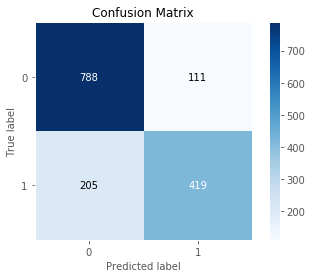

In [246]:
optimal_depth = 6
optimal_estimators = 200


xg_model = xgb.XGBClassifier(max_depth=optimal_depth, n_estimators=optimal_estimators, scale_pos_weight=1)
xg_model.fit(X_train,y_train)

pred = xg_model.predict(X_test)



print("***Test Data Report***")
print("Best max_depth = ",optimal_depth)
print("Best Base Learners = ",optimal_estimators)
fpr, tpr, threshold = metrics.roc_curve(y_test, lr.predict(X_test))
auc = metrics.auc(fpr, tpr)
print("AUC = ",auc*100)
skplt.metrics.plot_confusion_matrix(y_test, pred)
plt.show()

In [122]:
# test_pred = xg_model.predict(Test)

# submission['target'] = test_pred.astype(int)
# submission.to_csv('submission06xgb.csv', index=False)

### Stacking Classifier

In [177]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss
from sklearn.ensemble import StackingClassifier

sgd_stack1 = SGDClassifier(alpha=0.001, penalty='l2', loss='log', class_weight='balanced', random_state=0)
sgd_stack1.fit(X_train , y_train)

ccv_sgd_stack1 = CalibratedClassifierCV(sgd_stack1 , method="sigmoid")

sgd_stack2 = SGDClassifier(alpha=1, penalty='l2', loss='hinge', class_weight='balanced', random_state=0)
sgd_stack2.fit(X_train , y_train)

ccv_sgd_stack2 = CalibratedClassifierCV(sgd_stack2, method="sigmoid")


sgd_stack3 = MultinomialNB()
sgd_stack3.fit(X_train , y_train)

ccv_sgd_stack3 = CalibratedClassifierCV(sgd_stack3, method="sigmoid")

In [182]:
ccv_sgd_stack1.fit(X_train , y_train)
print("Logistic Regression :  Log Loss: %0.2f" % (log_loss(y_test , ccv_sgd_stack1.predict(X_test))))

ccv_sgd_stack3.fit(X_train , y_train)
print("Naive Bayes : Log Loss: %0.2f" % (log_loss(y_test , ccv_sgd_stack3.predict(X_test))))

ccv_sgd_stack2.fit(X_train , y_train)
print("Support vector machines : Log Loss: %0.2f" % (log_loss(y_test , ccv_sgd_stack2.predict(X_test))))
print("-"*50)

Logistic Regression :  Log Loss: 9.07
Naive Bayes : Log Loss: 8.71
Support vector machines : Log Loss: 7.60
--------------------------------------------------
